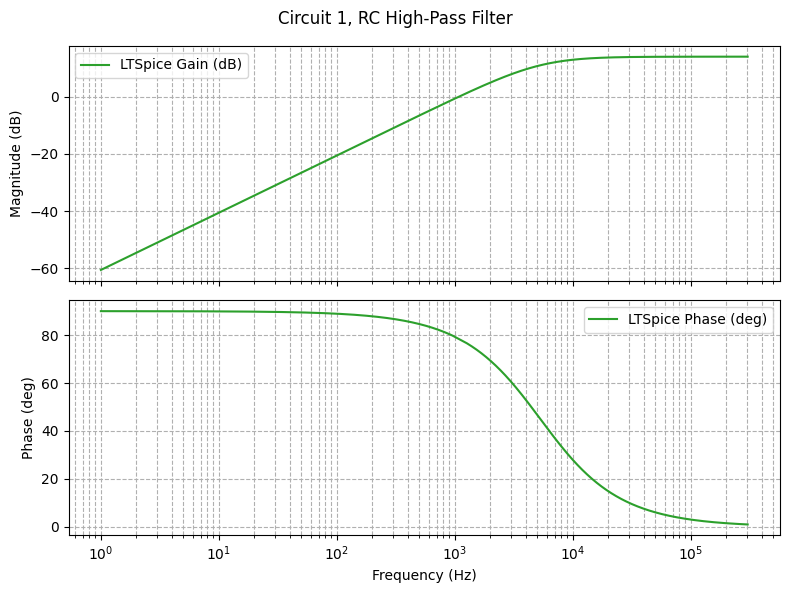

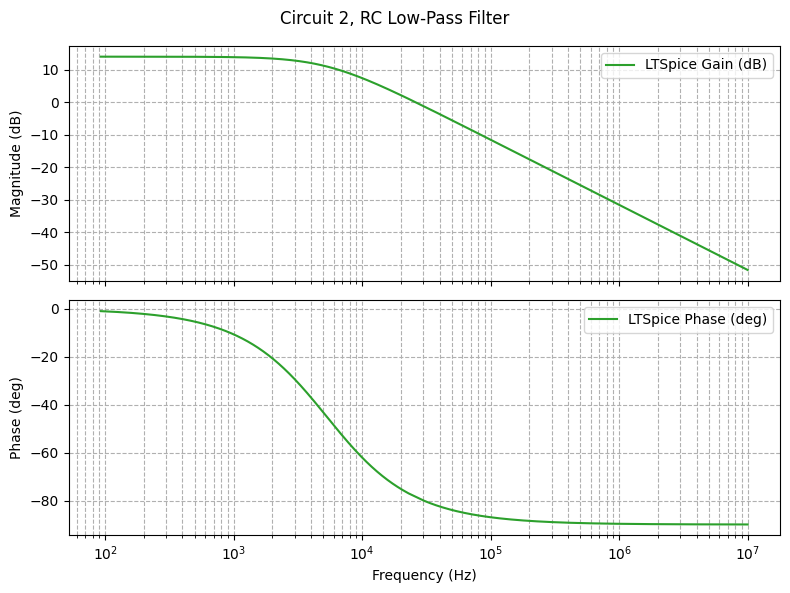

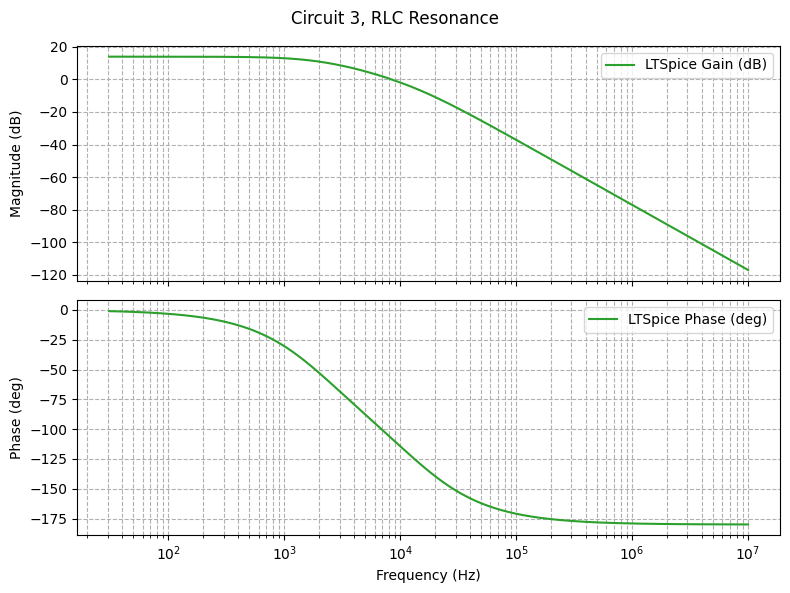

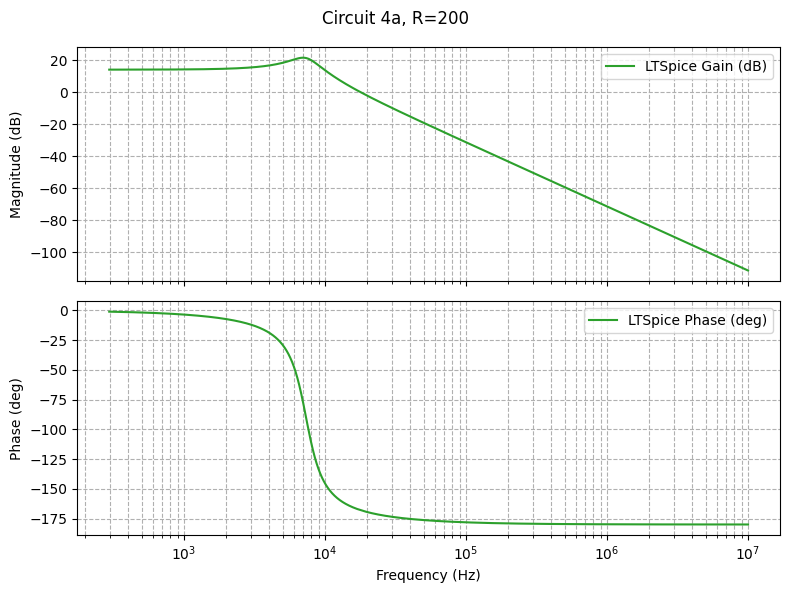

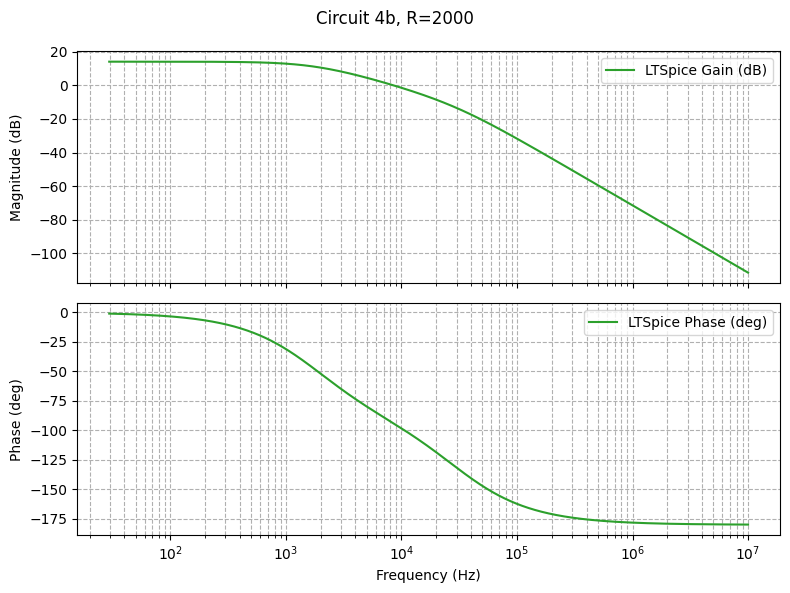


circuit1
  Max Gain: 13.98 dB
  Cutoff Level: 10.98 dB
  Lower Cutoff Frequency: 5308.84 Hz
  Upper Cutoff Frequency: Not found

circuit2
  Max Gain: 13.98 dB
  Cutoff Level: 10.98 dB
  Lower Cutoff Frequency: Not found
  Upper Cutoff Frequency: 5296.63 Hz

circuit3
  Max Gain: 13.98 dB
  Cutoff Level: 10.98 dB
  Lower Cutoff Frequency: Not found
  Upper Cutoff Frequency: 1981.53 Hz

circuit4a
  Max Gain: 21.45 dB
  Cutoff Level: 18.45 dB
  Lower Cutoff Frequency: 5105.05 Hz
  Upper Cutoff Frequency: 8472.27 Hz

circuit4b
  Max Gain: 13.98 dB
  Cutoff Level: 10.98 dB
  Lower Cutoff Frequency: Not found
  Upper Cutoff Frequency: 1786.49 Hz
13.9780723386588
13.9780747681302
13.9783686677126
21.4468039969581
13.9782157017905


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_and_plot(file_path, title, scopy_file=None):
    df = pd.read_csv(file_path, delimiter="\t", skiprows=1, encoding="ISO-8859-1", names=["Freq", "Magnitude"])
    df[['Magnitude_dB', 'Phase_deg']] = df['Magnitude'].str.extract(r'\((-?[\d\.e\+]+)dB,(-?[\d\.e\+]+)°\)')
    df['Magnitude_dB'] = pd.to_numeric(df['Magnitude_dB'])
    df['Phase_deg'] = pd.to_numeric(df['Phase_deg'])
    df['Freq'] = pd.to_numeric(df['Freq'])
    df = df.dropna(subset=['Magnitude_dB', 'Phase_deg', 'Freq'])


    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # LTSpice plots
    ax[0].semilogx(df['Freq'], df['Magnitude_dB'], label='LTSpice Gain (dB)', color='tab:green')
    ax[1].semilogx(df['Freq'], df['Phase_deg'], label='LTSpice Phase (deg)', color='tab:green')

    if scopy_file:
        df_scopy = pd.read_csv(scopy_file, skiprows=6, delimiter=",")
        df_scopy['Frequency(Hz)'] = pd.to_numeric(df_scopy['Frequency(Hz)'])
        df_scopy['Magnitude(dB)'] = pd.to_numeric(df_scopy['Magnitude(dB)'])
        df_scopy['Phase(°)'] = pd.to_numeric(df_scopy['Phase(°)'])


        scopy_mag_interp = np.interp(df['Freq'], df_scopy['Frequency(Hz)'], df_scopy['Magnitude(dB)'])
        scopy_phase_interp = np.interp(df['Freq'], df_scopy['Frequency(Hz)'], df_scopy['Phase(°)'])

        ax[0].semilogx(df['Freq'], scopy_mag_interp, label='Scopy Measured Gain', color='tab:blue', linestyle='dashed')
        ax[1].semilogx(df['Freq'], scopy_phase_interp, label='Scopy Measured Phase', color='tab:red', linestyle='dashed')

    ax[0].set_ylabel("Magnitude (dB)")
    ax[1].set_ylabel("Phase (deg)")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[0].legend()
    ax[1].legend()
    ax[0].grid(True, which="both", linestyle="--")
    ax[1].grid(True, which="both", linestyle="--")

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

    return df
file_paths = {
    '/home/art/school/ece2001/reports/report6/circuit1.txt': {
        'title': 'Circuit 1, RC High-Pass Filter',
        #'scopy': '/home/art/school/ece2001/reports/report6/scopy1.csv'
    },
    '/home/art/school/ece2001/reports/report6/circuit2.txt': {
        'title': 'Circuit 2, RC Low-Pass Filter',
        #'scopy': '/home/art/school/ece2001/reports/report6/scopy2.csv'
    },
    '/home/art/school/ece2001/reports/report6/circuit3.txt': {
        'title': 'Circuit 3, RLC Resonance',
        'scopy': None
    },
    '/home/art/school/ece2001/reports/report6/circuit4a.txt': {
        'title': 'Circuit 4a, R=200',
        #'scopy': '/home/art/school/ece2001/reports/report6/scopy4a.csv'
    },
    '/home/art/school/ece2001/reports/report6/circuit4b.txt': {
        'title': 'Circuit 4b, R=2000',
        #'scopy': '/home/art/school/ece2001/reports/report6/scopy4b.csv'
    },
}

dfs = {}
for idx, (path, info) in enumerate(file_paths.items()):
    dfs[idx] = read_and_plot(path, info['title'], scopy_file=info.get('scopy'))

circuit1 = dfs[0]
circuit2 = dfs[1]
circuit3 = dfs[2]
circuit4a = dfs[3]
circuit4b = dfs[4]

for name, df in zip(
    ["circuit1", "circuit2", "circuit3", "circuit4a", "circuit4b"],
    dfs.values()
):
    max_gain = df['Magnitude_dB'].max()
    cutoff_level = max_gain - 3

    # Index of peak gain
    peak_idx = df['Magnitude_dB'].idxmax()

    # Split data before and after peak
    before_peak = df.loc[:peak_idx]
    after_peak = df.loc[peak_idx:]
    before_cutoff = before_peak[before_peak['Magnitude_dB'] <= cutoff_level]
    freq_before = before_cutoff['Freq'].iloc[-1] if not before_cutoff.empty else None

    after_cutoff = after_peak[after_peak['Magnitude_dB'] <= cutoff_level]
    freq_after = after_cutoff['Freq'].iloc[0] if not after_cutoff.empty else None

    print(f"\n{name}")
    print(f"  Max Gain: {max_gain:.2f} dB")
    print(f"  Cutoff Level: {cutoff_level:.2f} dB")

    if freq_before:
        print(f"  Lower Cutoff Frequency: {freq_before:.2f} Hz")
    else:
        print("  Lower Cutoff Frequency: Not found")

    if freq_after:
        print(f"  Upper Cutoff Frequency: {freq_after:.2f} Hz")
    else:
        print("  Upper Cutoff Frequency: Not found")


print(max(circuit1['Magnitude_dB']))
print(max(circuit2['Magnitude_dB']))
print(max(circuit3['Magnitude_dB']))
print(max(circuit4a['Magnitude_dB']))
print(max(circuit4b['Magnitude_dB']))

